# Assignment 3. Logistic Regression and Random Forest in the credit scoring problem


In this assignment, you will build models and answer questions using data on credit scoring.

Please write your code in the cells with the "Your code here" placeholder. Then, answer the questions in the [form](https://docs.google.com/forms/d/1gKt0DA4So8ohKAHZNCk58ezvg7K_tik26d9QND7WC6M/edit).

Let's start with a warm-up exercise.

**Question 1.** There are 5 jurors in a courtroom. Each of them can correctly identify the guilt of the defendant with 70% probability, independent of one another. What is the probability that the jurors will jointly reach the correct verdict if the final decision is by majority vote?

1. 70.00%
2. 83.20%
3. **83.70%**
4. 87.50%

Answer: We need at least 3 positive outcomes, so the following outcomes are possible for a correct decision:

p = probability = 0.7<br/>
X = num of positive outcomes >=3<br/>
n = total trials = 5<br/>

$P(X>=3) = P(3) + P(4) + P(5)$

$P(X) = \binom{n}{k}*p^X*(1-p)^(n-X)$

=> $P(3)=0.3087$<br/>
=> $P(4)=0.36015$<br/>
=> $P(5)=0.16807$<br/>

=> $P(X>=3) = P(3) + P(4) + P(5) = 0.3087 + 0.36015 + 0.16807 = 0.83692$

Great! Let's move on to machine learning.

## Credit scoring problem setup

#### Problem

Predict whether the customer will repay their credit within 90 days. This is a binary classification problem; we will assign customers into good or bad categories based on our prediction.

#### Data description

| Feature | Variable Type | Value Type | Description |
|:--------|:--------------|:-----------|:------------|
| age | Input Feature | integer | Customer age |
| DebtRatio | Input Feature | real | Total monthly loan payments (loan, alimony, etc.) / Total monthly income percentage |
| NumberOfTime30-59DaysPastDueNotWorse | Input Feature | integer | The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years |
| NumberOfTimes90DaysLate | Input Feature | integer | Number of cases when customer had 90+dpd overdue on other credits |
| NumberOfTime60-89DaysPastDueNotWorse | Input Feature | integer | Number of cased when customer has 60-89dpd (not worse) during the last 2 years |
| NumberOfDependents | Input Feature | integer | The number of customer dependents |
| SeriousDlqin2yrs | Target Variable | binary: <br>0 or 1 | Customer hasn't paid the loan debt within 90 days |


Let's set up our environment:

In [1]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

np.random.seed(0)

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

Let's write the function that will replace *NaN* values with the median for each column.

In [3]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table   

Now, read the data:

In [4]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep =';')
data.head()

SeriousDlqin2yrs  age  NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  \
0                 0   64                                     0     0.249908   
1                 0   58                                     0  3870.000000   
2                 0   41                                     0     0.456127   
3                 0   43                                     0     0.000190   
4                 1   49                                     0     0.271820   

   NumberOfTimes90DaysLate  NumberOfTime60-89DaysPastDueNotWorse  \
0                        0                                     0   
1                        0                                     0   
2                        0                                     0   
3                        0                                     0   
4                        0                                     0   

   MonthlyIncome  NumberOfDependents  
0         8158.0                 0.0  
1            NaN                 0.0  
2         6666.0                 0.0  
3        10500.0                 2.0  
4          400.0                 0.0

Look at the variable types:

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Check the class balance:

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

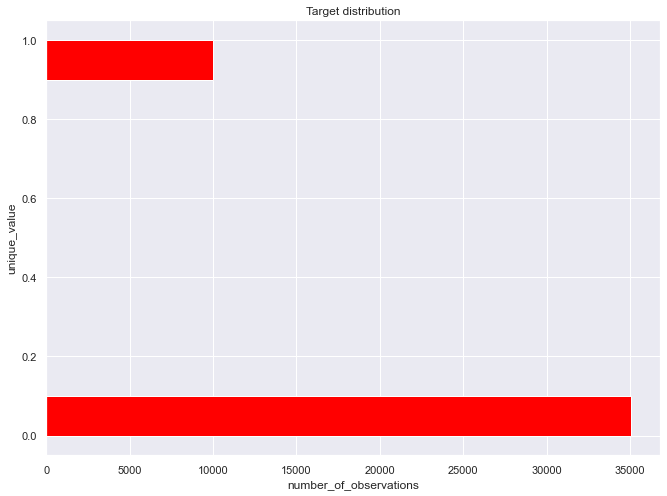

In [6]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

Separate the input variable names by excluding the target:

In [7]:
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Apply the function to replace *NaN* values:

In [8]:
table = fill_nan(data)

Separate the target variable and input features:

In [9]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

## Bootstrapping

**Question 2.** Make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level. Use the example from the article as reference, if needed. Also, use `np.random.seed(0)` as before. What is the resulting interval estimate?

1. 52.59 – 52.86
2. **45.71 – 46.13**
3. 45.68 – 46.17
4. 52.56 – 52.88

In [10]:
# Your code here
import scipy.stats as st
from scipy.stats import bootstrap
np.random.seed(0)
age = data[data["SeriousDlqin2yrs"] == 1]["age"] # filter out the age of people who haven't paid
st.norm.interval(alpha=0.9, loc=age.mean(), scale=st.sem(age))

(45.714412469000294, 46.13876925850819)

## Logistic regression

Let's set up to use logistic regression:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Now, we will create a `LogisticRegression` model and use `class_weight='balanced'` to make up for our unbalanced classes.

In [12]:
lr = LogisticRegression(random_state=5, class_weight='balanced')

Let's try to find the best regularization coefficient, which is the coefficient `C` for logistic regression. Then, we will have an optimal model that is not overfit and is a good predictor of the target variable.

In [13]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In order to find the optimal value of `C`, let's apply stratified 5-fold validation and look at the *ROC AUC* against different values of the parameter `C`. Use the `StratifiedKFold` function for this: 

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

One of the important metrics of model quality is the *Area Under the Curve (AUC)*. *ROC AUC* varies from 0 to 1. The closer ROC AUC is to 1, the better the quality of the classification model.

**Question 3.** Perform a *Grid Search* with the scoring metric "roc_auc" for the parameter `C`. Which value of the parameter `C` is optimal? 

1. 0.0001
2. **0.001**
3. 0.01
4. 0.1
5. 1
6. 10

In [15]:
# Your code here
gscv = GridSearchCV(estimator=lr, param_grid=parameters, scoring="roc_auc", cv=skf)

gscv.fit(X,y)
best_c = gscv.best_params_['C']
print(f"Best C: {best_c}")

Best C: 0.001


**Question 4.** Can we consider the best model stable? The model is *stable* if the standard deviation on validation is less than 0.5%. Save the *ROC AUC* value of the best model; it will be useful for the following tasks.

1. Yes
2. **No**

In [16]:
# Your code here
print(f"Standard Deviation of best coefficient: {(gscv.cv_results_['std_test_score'][gscv.best_index_] * 100).__round__(2)}%")
logistic_roc_auc = gscv.best_score_
print(f"ROC AUC score: {logistic_roc_auc}")

Standard Deviation of best coefficient: 0.81%
ROC AUC score: 0.8089120626797153


## Feature importance

**Question 5.** *Feature importance* is defined by the absolute value of its corresponding coefficient. First, you need to normalize all of the feature values so that it will be valid to compare them. What is the most important feature for the best logistic regression model?

1. age
2. **NumberOfTime30-59DaysPastDueNotWorse**
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

In [17]:
# Your code here
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic regression', LogisticRegression(C = best_c, random_state=5, class_weight='balanced'))
])
pipe.fit(X,y)
coefs = list(pipe.named_steps['logistic regression'].coef_.ravel())
print(f"Most important feature: {independent_columns_names[coefs.index(max(coefs))]}\nCoefficient: {max(coefs)}")

Most important feature: NumberOfTime30-59DaysPastDueNotWorse
Coefficient: 0.723426981328996


**Question 6.** Calculate how much `DebtRatio` affects our prediction using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function). What is its value?

1. 0.38
2. -0.02
3. **0.11**
4. 0.24

In [18]:
# Your code here
from scipy.special import softmax
list(softmax(coefs))[independent_columns_names.index("DebtRatio")]

0.11426375283065272

**Question 7.** Let's see how we can interpret the impact of our features. For this, recalculate the logistic regression with absolute values, that is without scaling. Next, modify the customer's age by adding 20 years, keeping the other features unchanged. How many times will the chance that the customer will not repay their debt increase? You can find an example of the theoretical calculation [here](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf).

1. -0.01
2. 0.70
3. 8.32
4. **0.66**

In [19]:
# Your code here
# modify age
X_20 = X.copy()
X_20['age'] = X['age']+20

# get predictions with unmodified and modified age
lr = LogisticRegression(C=best_c, random_state=5, class_weight='balanced')
lr.fit(X,y)

pred_normal = lr.predict(X)
pred_aged = lr.predict(X_20)

# comparing predicted values
unique, counts = np.unique(pred_normal, return_counts=True)
normals = dict(zip(unique,counts))

unique, counts = np.unique(pred_aged, return_counts=True)
aged = dict(zip(unique, counts))

print(normals, aged)

{0: 34154, 1: 10909} {0: 38137, 1: 6926}


In [20]:
percentage_normal = normals[1]/(normals[0]+normals[1])
percentage_aged = aged[1]/(aged[0]+aged[1])
print(f"Normal: {percentage_normal}\nAged: {percentage_aged}")
print(f"Increase: {percentage_aged/percentage_normal}")

Normal: 0.24208330559439006
Aged: 0.15369593679959168
Increase: 0.6348886240718673


## Random Forest

Import the Random Forest classifier:

In [21]:
from sklearn.ensemble import RandomForestClassifier

Initialize Random Forest with 100 trees and balance target classes:

In [22]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, 
                            class_weight='balanced')

We will search for the best parameters among the following values:

In [23]:
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

Also, we will use the stratified k-fold validation again. You should still have the `skf` variable.

**Question 8.** How much higher is the *ROC AUC* of the best random forest model than that of the best logistic regression on validation?

1. 4%
2. **3%**
3. 2%
4. 1%

In [24]:
# Your code here
gscv = GridSearchCV(estimator=rf, param_grid=parameters, scoring="roc_auc", cv=skf)
gscv.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             scoring='roc_auc')

In [25]:
rfc_roc_auc = gscv.best_score_
print(f"Logistic Regression ROC AUC score: {logistic_roc_auc}\nRandom Forest Classifier ROC AUC score: {rfc_roc_auc}")
print(f"Percentage increase: {(((rfc_roc_auc/logistic_roc_auc)-1)*100).__round__(2)}")
print(f"Flat Increase: {((rfc_roc_auc-logistic_roc_auc)*100).__round__(2)}")
max_features = gscv.best_params_['max_features']
min_samples_leaf = gscv.best_params_['min_samples_leaf']
max_depth = gscv.best_params_['max_depth']

Logistic Regression ROC AUC score: 0.8089120626797153
Random Forest Classifier ROC AUC score: 0.8357785451032532
Percentage increase: 3.32
Flat Increase: 2.69


**Question 9.** What feature has the weakest impact in the Random Forest model?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. **NumberOfDependents**

In [26]:
# Your code here
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('random forest', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42,
                            class_weight='balanced', max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf))
])
pipe.fit(X,y)
feature_importances = list(pipe.named_steps['random forest'].feature_importances_)
print(f"Least important feature: {independent_columns_names[feature_importances.index(min(feature_importances))]}\nCoefficient: {min(feature_importances)}")

Least important feature: NumberOfDependents
Coefficient: 0.014676156708250628


**Question 10.** What is the most significant advantage of using *Logistic Regression* versus *Random Forest* for this problem?

1. Spent less time for model fitting;
2. Fewer variables to iterate;
3. **Feature interpretability;**
4. Linear properties of the algorithm.

## Bagging

Import modules and set up the parameters for bagging:

In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]}

**Question 11.** Fit a bagging classifier with `random_state=42`. For the base classifiers, use 100 logistic regressors and use `RandomizedSearchCV` instead of `GridSearchCV`. It will take a lot of time to iterate over all 54 variants, so set the maximum number of iterations for `RandomizedSearchCV` to 20. Don't forget to set the parameters `cv` and `random_state=1`. What is the best *ROC AUC* you achieve?

1. **80.75%**
2. 80.12%
3. 79.62%
4. 76.50%

In [28]:
# Your code here
bc = BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'), n_estimators=100, random_state=42, n_jobs=-1)

rscv = RandomizedSearchCV(estimator=bc, param_distributions=parameters, scoring="roc_auc", cv=skf, n_iter=20, random_state=1, n_jobs=-1)
rscv.fit(X,y)
print(f"Best parameters: {rscv.best_params_}")
print(f"ROC AUC score: {rscv.best_score_}")

Best parameters: {'max_samples': 0.9, 'max_features': 2, 'base_estimator__C': 100}
ROC AUC score: 0.8087951623513827


**Question 12.** Give an interpretation of the best parameters for bagging. Why are these values of `max_features` and `max_samples` the best?

1. For bagging it's important to use as few features as possible;
2. Bagging works better on small samples;
3. **Less correlation between single models;**
4. The higher the number of features, the lower the loss of information.

Author: Vitaly Radchenko. All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.